# Imports and loads

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
# df05ht = pd.read_csv('../data/raw/data_live_scores.csv').reset_index(drop=True)
df05ht = pd.read_csv('data_live_scores.csv').reset_index(drop=True)
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2023-08-20,0:36,Aston Villa FC,Everton FC,England - Premier League,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,
1,2023-08-20,0:53,Aston Villa FC,Everton FC,England - Premier League,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-08-20-Aston Villa FC-Everton FC
2,2023-08-20,2:00,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-08-20-Aston Villa FC-Everton FC
3,2023-08-20,3:07,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-08-20-Aston Villa FC-Everton FC
4,2023-08-20,4:13,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-08-20-Aston Villa FC-Everton FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259879,2022-08-20,42:31,Motherwell FC,Livingston FC,Scotland - Premiership,0.0,0.0,0.0,0.0,3.0,...,6.0,7.0,7.0,6.0,2.0,0.0,10.0,7.0,0,2022-08-20-Motherwell FC-Livingston FC
1259880,2022-08-20,43:35,Motherwell FC,Livingston FC,Scotland - Premiership,0.0,0.0,0.0,0.0,3.0,...,6.0,7.0,7.0,6.0,2.0,0.0,10.0,7.0,0,2022-08-20-Motherwell FC-Livingston FC
1259881,2022-08-20,44:39,Motherwell FC,Livingston FC,Scotland - Premiership,0.0,0.0,0.0,0.0,3.0,...,6.0,7.0,7.0,6.0,2.0,0.0,10.0,7.0,0,2022-08-20-Motherwell FC-Livingston FC
1259882,2022-08-20,45+0:43,Motherwell FC,Livingston FC,Scotland - Premiership,0.0,0.0,0.0,0.0,3.0,...,6.0,7.0,7.0,6.0,2.0,0.0,10.0,7.0,0,2022-08-20-Motherwell FC-Livingston FC


In [3]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

# Preprocess

In [4]:
print(df05ht.shape)
df05ht = df05ht.dropna()
print(df05ht.dropna().shape)

(1259884, 27)
(1259229, 27)


In [5]:
df05ht.drop_duplicates(inplace=True)
df05ht.shape

(138438, 27)

In [6]:
# df05ht.to_csv('data_live_socres_clean.csv', index=False)

In [6]:
new_columns_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df05ht = df05ht.rename(columns=new_columns_names)

In [7]:
df05ht['possessiontime_away'] = (df05ht['passes_away'] / (df05ht['passes_away'] + df05ht['passes_home'])) * 100
df05ht['possessiontime_home'] = (df05ht['passes_home'] / (df05ht['passes_away'] + df05ht['passes_home'])) * 100


In [8]:
df05ht.drop(columns=["date",'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away'], inplace=True)

In [9]:
df05ht.shape

(138438, 24)

In [10]:
leagues_opta = df05ht['league'].unique()

In [11]:
for league in leagues_opta:
    print(league)

England - Premier League
Germany - Bundesliga
Spain - Primera División
France - Ligue 1
USA - MLS
Italy - Serie A
Brazil - Serie A
Netherlands - Eredivisie
England - Championship
Portugal - Primeira Liga
Romania - Liga I
World - FIFA Women's World Cup
England - League One
England - League Two
Europe - UEFA Europa Conference League
England - League Cup
Europe - UEFA Super Cup
Europe - UEFA Champions League
Germany - DFB Pokal
Italy - Coppa Italia
Scotland - Premiership
Germany - Super Cup
South America - CONMEBOL Libertadores
England - Community Shield
N/C America - Concacaf Gold Cup
Europe - UEFA U21 Championship
Romania - Supercupa
Romania - Play-offs 1/2
Australia - A-League Men
Portugal - Play-offs 1/2
Europe - UEFA European Championship Qualifiers
Germany - Play-offs 1/2
Europe - UEFA Nations League
Europe - UEFA Europa League
England - FA Cup
Spain - Copa del Rey
World - FIFA World Cup
France - Coupe de France
Spain - Super Cup
Italy - Super Cup
World - FIFA Club World Cup


In [12]:
# df[df['league'] == "Europe - UEFA European Championship Qualifiers"].tail(1)
# 'Australia - A-League Men': 'Australia - A-League',

In [13]:
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Romania - Supercupa': 'Romania - Super Cup',
    'Romania - Play-offs 1/2': 'Romania - Liga 1 - Play-offs',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',

}

print(len(name_mapping))
print(len(leagues_opta))

# Atualize os nomes das ligas em df05ht
df05ht['league'] = df05ht['league'].replace(name_mapping)


41
41


In [14]:
# # Define a variável alvo
target = 'result'

print(len(df05ht['match_id'].unique()))
print(df05ht['result'].value_counts())
print(len(df05ht))

4420
0    109509
1     28929
Name: result, dtype: int64
138438


In [15]:
df05ht.shape

(138438, 24)

In [16]:
def convert_to_int_minutes(value):
    if '+' in value:
        # Separando o tempo base e o acréscimo
        base_time, added_time = value.split('+')
        added_minutes = int(added_time.split(':')[0])  # Ignorando os segundos, pegando apenas os minutos do acréscimo
    else:
        base_time = value
        added_minutes = 0
    
    # Convertendo o tempo base em minutos
    base_minutes = int(base_time.split(':')[0]) if ':' in base_time else int(base_time)
    
    # Somando os minutos
    total_minutes = base_minutes + added_minutes
    return total_minutes


# Aplicando a função para converter os minutos
df05ht['minute'] = df05ht['minute'].apply(convert_to_int_minutes)

In [17]:
len(df05ht['match_id'].unique())

4420

In [18]:
# 1. Identify leagues with only one unique value in 'result' column
single_value_leagues = df05ht.groupby('league').apply(lambda x: len(x['result'].unique()) == 1)

# 2. Identify leagues with fewer than 100 matches
few_matches_leagues = df05ht['league'].value_counts()
few_matches_leagues = few_matches_leagues[few_matches_leagues < 100].index.tolist()

# Combine the lists of leagues to drop
leagues_to_drop = single_value_leagues[single_value_leagues].index.tolist() + few_matches_leagues

# Drop the identified leagues
filtered_data = df05ht[~df05ht['league'].isin(leagues_to_drop)]

# 3. Balance the 'result' column for each remaining league
balanced_data = []
for league in filtered_data['league'].unique():
    league_data = filtered_data[filtered_data['league'] == league]
    min_count = league_data['result'].value_counts().min()
    
    # Sample 'min_count' examples from each result value
    balanced_samples = [league_data[league_data['result'] == result_val].sample(min_count, random_state=42) for result_val in [0, 1]]
    balanced_data.extend(balanced_samples)

# Combine the balanced data samples
balanced_data = pd.concat(balanced_data, axis=0)
balanced_data.dropna(inplace=True)

# Display the first few rows of the balanced data and the list of dropped leagues
leagues_to_drop


['England - Community Shield',
 'Germany - Bundesliga Play-offs',
 'Italy - Super Cup',
 'Romania - Super Cup',
 'Romania - Liga 1 - Play-offs',
 'Spain - Super Cup',
 'England - Community Shield',
 'Romania - Super Cup',
 'Europe - Uefa Super Cup',
 'Portugal - Primeira Liga - Play-offs',
 'Italy - Super Cup',
 'Germany - Bundesliga Play-offs',
 'Germany - Super Cup']

In [19]:
df = balanced_data.copy()
df.shape

(57657, 24)

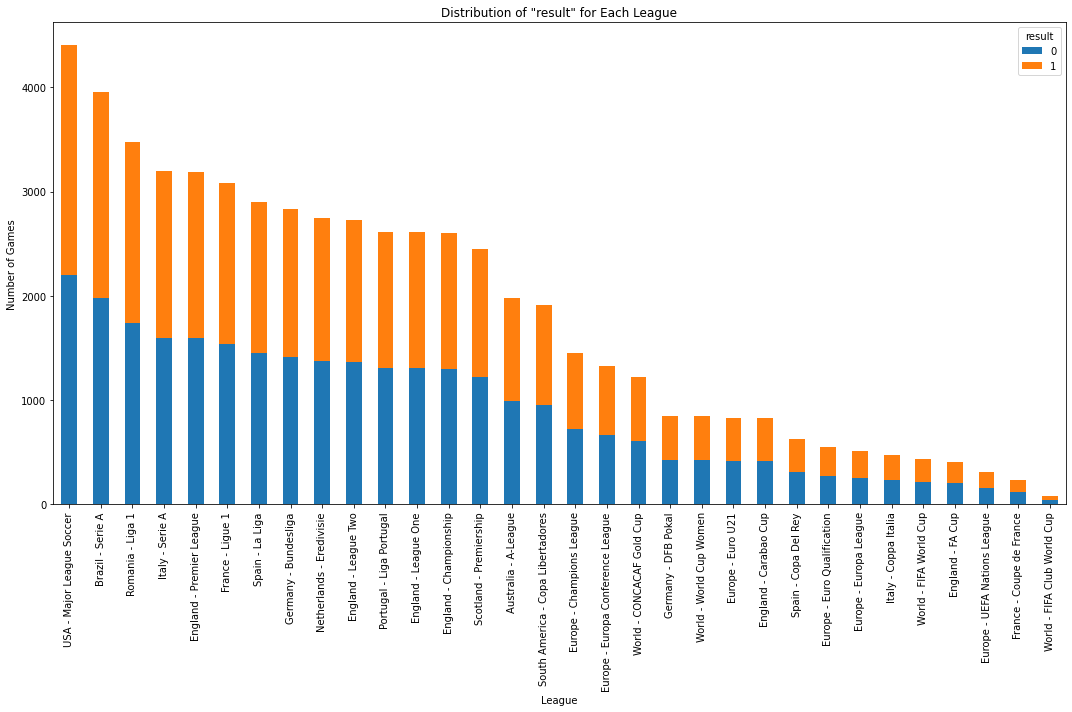

In [20]:
# Group the data by league and result and get the size of each group
league_distribution = df.groupby(['league', 'result']).size().unstack().fillna(0)

# Sort the leagues based on the total number of games
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

# Plot
plt.figure(figsize=(15, 10))
league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of "result" for Each League')
plt.ylabel('Number of Games')
plt.xlabel('League')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


In [21]:
df['result'].value_counts()

1    28832
0    28825
Name: result, dtype: int64

In [22]:
df.shape

(57657, 24)

In [23]:
df = df.sort_values('minute').reset_index(drop=True)
# df.to_csv('data_live_scores_balanced.csv', index=False)
# df = pd.read_csv('data_live_scores_balanced.csv')

In [25]:
# IDs únicos no DataFrame
unique_ids = df['match_id'].unique()

invalid_ids = []

for game_id in unique_ids:
    # Obtenha as minutagens para o ID atual
    game_df = df[df['match_id'] == game_id]
    
    # Verifique se há minutos fora do intervalo permitido (maior que 57)
    if any(game_df['minute'] > 57):
        invalid_ids.append(game_id)
        continue  # Pode pular para o próximo ID já que este é inválido
    
# Remova os IDs inválidos do DataFrame original
df_clean = df[~df['match_id'].isin(invalid_ids)]

In [26]:
print(df_clean.shape)
print(df.shape)

(57605, 24)
(57657, 24)


In [27]:
df = df_clean

In [28]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')

In [29]:


# Separando os dados em características e variável alvo
X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
y = df['result']

# Definindo as colunas numéricas e categóricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = ['league']

# Criando o transformador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Aplicando as transformações
X = preprocessor.fit_transform(X)

with open(f'../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,train_size=0.80, random_state=42)

# Modeling

## Automl h2o

In [32]:


# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["col_" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["col_" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

# Run AutoML
aml = H2OAutoML(max_models=20, seed=42)
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Pichau\AppData\Local\Temp\tmptu3e29ag
  JVM stdout: C:\Users\Pichau\AppData\Local\Temp\tmptu3e29ag\h2o_Pichau_started_from_python.out
  JVM stderr: C:\Users\Pichau\AppData\Local\Temp\tmptu3e29ag\h2o_Pichau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_Pichau_750iy1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (46084, 50)
y_train_h2o shape: (46084, 1)
X_test_h2o shape: (11521, 50)
y_test_h2o shape: (11521, 1)
AutoML progress: |
12:04:43.848: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_bbd55f7096e81931c3b39372363442fe> was cancelled by the user.

In [ ]:


loaded_model = h2o.load_model('model_automl.h5')
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: importModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/c:/Users/Pichau/Desktop/eofut/notebooks/model_automl.h5 msg: File not found
  Request: POST /99/Models.bin/
    data: {'dir': 'model_automl.h5'}


## Random Forest

In [104]:
# teste com random forest foi feito mas não atingiu uma boa espectativa 
# # Criando o modelo base
# # rfc = RandomForestClassifier(n_estimators=1000,max_depth=40, min_samples_leaf=1, min_samples_split=30, max_features=None, random_state=1, n_jobs=-1)
# rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # # # Treinando o modelo com os melhores hiperparâmetros
# rfc.fit(X_train, y_train)

# predictions = rfc.predict(X_test)
# accuracy = accuracy_score(y_test, predictions)


# print(f" Teste Acurácia do modelo Random Forest: {accuracy * 100:.2f}%")
# print(f"Erro quadrático médio: {mean_squared_error(y_test, predictions)}")
# print(f"Treino Acurácia do modelo Random Forest: {rfc.score(X_train, y_train) * 100:.2f}%")

# with open(f'random_forestht.pkl', 'wb') as f:
#     pickle.dump(rfc, f)

## Neural Network Keras

Epoch 1/500
721/721 [==============================] - 2s 2ms/step - loss: 0.6870 - accuracy: 0.5360 - precision: 0.5335 - recall: 0.5593 - val_loss: 0.6823 - val_accuracy: 0.5423 - val_precision: 0.5570 - val_recall: 0.4446
Epoch 2/500
721/721 [==============================] - 1s 2ms/step - loss: 0.6737 - accuracy: 0.5703 - precision: 0.5649 - recall: 0.6052 - val_loss: 0.6736 - val_accuracy: 0.5715 - val_precision: 0.5551 - val_recall: 0.7504
Epoch 3/500
721/721 [==============================] - 1s 2ms/step - loss: 0.6588 - accuracy: 0.5973 - precision: 0.5900 - recall: 0.6334 - val_loss: 0.6618 - val_accuracy: 0.5906 - val_precision: 0.5748 - val_recall: 0.7183
Epoch 4/500
721/721 [==============================] - 1s 2ms/step - loss: 0.6414 - accuracy: 0.6210 - precision: 0.6123 - recall: 0.6559 - val_loss: 0.6501 - val_accuracy: 0.6041 - val_precision: 0.5929 - val_recall: 0.6821
Epoch 5/500
721/721 [==============================] - 1s 2ms/step - loss: 0.6246 - accuracy: 0.6369

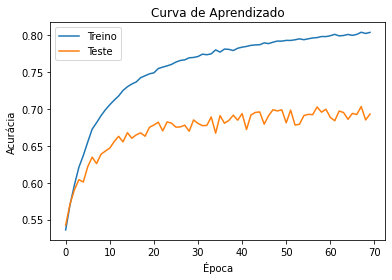

In [31]:
predictions = []
  
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', 'Precision', 'Recall'])




early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
# history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)



# Faz a predição utilizando os dados de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo no conjunto de treinamento e conjunto de teste
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy on training set:', train_acc)
print('Accuracy on test set:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# save model .h5
model.save('model_redeht.h5')

In [106]:
# h2o.cluster().shutdown()


# In pratice

In [107]:
h2o.init()
loaded_model = h2o.load_model("C:/Users/Pichau/Desktop/eo-fut-live/models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 22 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,30 days
H2O_cluster_name:,H2O_from_python_Pichau_eas44d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.820 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.589734,0.410266


In [108]:
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.410265916561806